# Pregnancy cfDNA  

validation of CelFiE on pregnancy data from Jensen et al 2016 Genome Biol 

## Imports and set up 

In [1]:
import pandas as pd
import numpy as np 
import pickle as pkl 
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os 

In [2]:
# import R to be used in python 
import rpy2
%load_ext rpy2.ipython

In [3]:
os.chdir("/Users/christacaggiano/Desktop/zaitlen_lab_desktop/")  # set working directory 

In [4]:
# set white seaborn plotting style 
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')

## Functions

In [5]:
def load_pickles(directory, ref_labels, ind_labels, timepoint, status):
    """
    load the CelFiE estimates that were saved as a pickle file and call pickle to df to 
    label them with the relelvant clinical information 
    """
    pickle_files = glob.glob(directory + "/*alpha.pkl")
    pickle_list = []
    for file in pickle_files:
        f = open(file, "rb")
        pickle_list.append(pkl.load(f))
        f.close()
        
    return pickle_to_df(pickle_list, ref_labels, ind_labels, timepoint, status)


In [6]:
def pickle_to_df(pickle_list, ref_labels, ind_labels, timepoint, status):
    """
    label the pickle files of CelFiE estimates and transform into dataframe 
    """
    df = pd.DataFrame(columns={"estimate", "individual", "tissue", "timepoint", "status", "trimester"})  # initialize df 

    for pickle in pickle_list:
        for i, individual in enumerate(pickle):  # for each individual 
            for j, estimate in enumerate(individual):  # for each tissue 
                
                # determine trimester based on gestational age 
                trimester = np.nan 
                if timepoint[i] <=12: 
                    trimester = "trimester 1"
                if timepoint[i] > 12: 
                    trimester = "trimester 2"
                
                df = df.append({"estimate":estimate, "individual":ind_labels[i], 
                                "tissue":ref_labels[j], "timepoint":timepoint[i], 
                               "status":status[i], "trimester":trimester}, ignore_index=True)
    return df

In [7]:
def add_iteration(num, df): 
    """
    add information about random restart # 
    """
    df["iteration"] = 0 
    for i in range(0, len(df), num): 
        df.iloc[i:i+num, -1] = i//num

## Labels

In [8]:
# reference labels for tissue proportions celfie is estimating 
# note 1 unknown 

reference_labels = ["dendritic", "endothelial", "eosinophil", "erythroblast", "macrophage", "memory b", 
            "monocyte", "natural killer",  "neutrophil", "placenta", "t cell cd8", "t cell cd4",
            "adipose", "hepatocyte", "pancreas", "skeletal muscle", "small intestine", 
            "spleen", "stomach", "tibial nerve", "unknown"]


In [9]:
# lists to label the individuals with basic information 

individual_labels = ["nonpreg1", "nonpreg2", "nonpreg3", "nonpreg4", "nonpreg5", "nonpreg6", "nonpreg7", "nonpreg8", 
       "preg1", "preg2", "preg3", "preg4", "preg5", "preg6", "preg7"]

preg_status = ["not pregnant", "not pregnant", "not pregnant", "not pregnant", "not pregnant", "not pregnant",
          "not pregnant", "not pregnant","pregnant", "pregnant", "pregnant", "pregnant", "pregnant",
          "pregnant", "pregnant"]

gest_age = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 22, 20, 18, 10, 11, 16, 25]


In [10]:
# load celfie estimates
preg = load_pickles("jensen_preg_tims03", reference_labels, individual_labels, gest_age, preg_status)

In [11]:
# select best random restart for remaining analyses 
add_iteration(len(individual_labels)*len(reference_labels), preg)
preg_bestrr = preg[preg.iteration == 1]

In [12]:
preg_bestrr.to_csv("preg_tims03.csv", index=False)

## Plot 

### All CelFiE estimates 

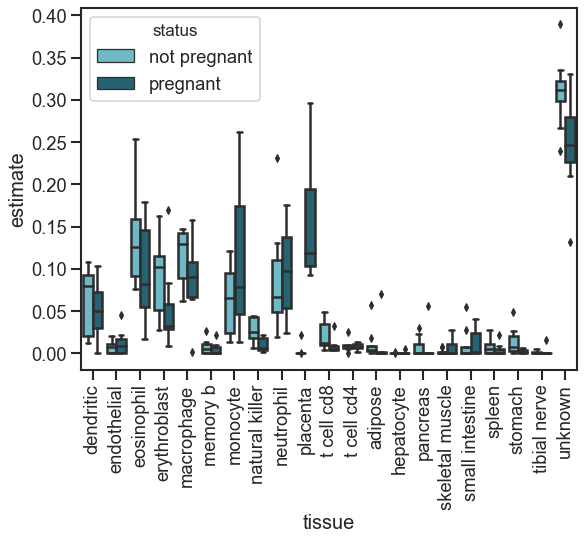

In [13]:
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.set_context("talk")
color_palette = sns.color_palette(["#61c2d3", "#196a7d"])

g = sns.boxplot("tissue", "estimate", hue="status", data=preg_bestrr, palette=color_palette)
plt.xticks(rotation=90)
plt.show()

### Unknowns

In [14]:
unknown = preg_bestrr[preg_bestrr.tissue == "unknown"]
print("pregnant", unknown[unknown["status"]=="pregnant"]["estimate"].mean())
print("not pregnant", unknown[unknown["status"]!="pregnant"]["estimate"].mean())

pregnant 0.24612892804174785
pregnant unknown avg 0.3103567440690981


In [15]:
unknown = preg_bestrr[preg_bestrr.tissue == "unknown"]
print("pregnant", unknown[unknown["status"]=="pregnant"]["estimate"].std())
print("not pregnant", unknown[unknown["status"]!="pregnant"]["estimate"].std())

pregnant 0.0631609188195379
pregnant unknown avg 0.04439997930041219


### Placenta

In [45]:
# subset tissues to just on placenta 
placenta = preg_bestrr[preg_bestrr.tissue == "placenta"]

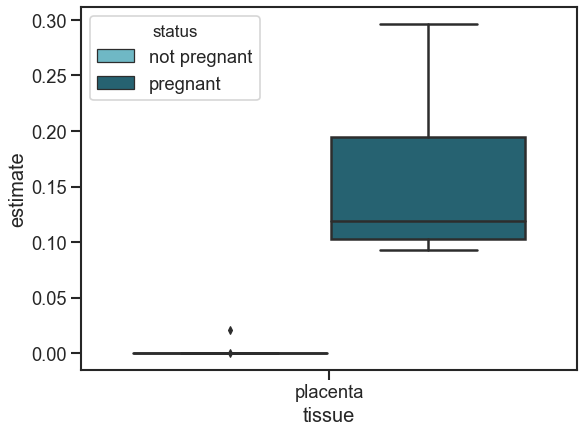

In [46]:
# placenta plotted by pregnant vs not pregnant 

fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.set_context("talk")
color_palette = sns.color_palette(["#61c2d3", "#196a7d"])

g = sns.boxplot("tissue", "estimate", hue="status", data=placenta, palette=color_palette)
plt.show()

In [52]:
# subset placenta by pregnancy status 
pregnant_placenta = placenta[placenta.status == "pregnant"]
nonpregnant_placenta = placenta[placenta.status != "pregnant"]

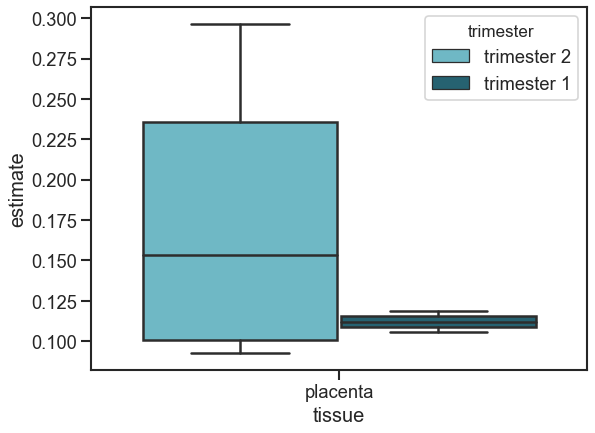

In [49]:
# plot placenta estimates by trimester 
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.set_context("talk")
color_palette = sns.color_palette(["#61c2d3", "#196a7d"])

g = sns.boxplot("tissue", "estimate", hue="trimester", data=pregnant_placenta, palette=color_palette)
plt.show()

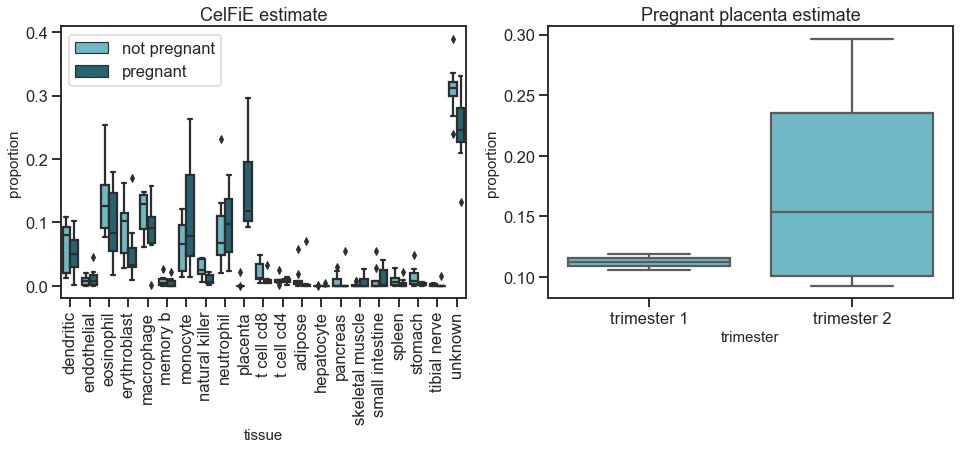

In [62]:
# plot estimates and placenta by trimester 

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(16,5))
sns.set_context("talk")

sns.boxplot("tissue", "estimate", hue="status", data=preg_bestrr, palette=color_palette, ax=ax1)

sns.boxplot("trimester", "estimate", data=pregnant_placenta, 
            order = ["trimester 1", "trimester 2"], color = "#61c2d3", ax=ax2)

ax1.set_ylabel("proportion", fontsize=15)
ax2.set_ylabel("proportion", fontsize=15)

ax1.set_xlabel("tissue", fontsize=15)
ax2.set_xlabel("trimester", fontsize=15)

for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

ax1.set_title("CelFiE estimate")
ax2.set_title("Pregnant placenta estimate")

legend = ax1.legend()
legend.texts[0].set_text("not pregnant")
legend.texts[1].set_text("pregnant")

plt.show()

## Statistics 

In [55]:
# pregnant women placenta estimates 
print(pregnant_placenta["estimate"].median())
print(pregnant_placenta["estimate"].mean())
print(pregnant_placenta["estimate"].min())
print(pregnant_placenta["estimate"].max())

0.11865732709344999
0.15752897504173788
0.09257128866208665
0.29657150236863006


In [59]:
# placenta estimates by trimester 
pregnant_placenta.groupby("trimester")["estimate"].median()

trimester
trimester 1    0.112048
trimester 2    0.153433
Name: estimate, dtype: float64

In [57]:
# nonpregnant placenta estimates 
print(nonpregnant_placenta["estimate"].median())
print(nonpregnant_placenta["estimate"].mean())  
print(nonpregnant_placenta["estimate"].min())
print(nonpregnant_placenta["estimate"].max())  # high outlier relative to other women 

2.265169232045735e-12
0.0026578921870419295
2.908100679068592e-16
0.021260392717947933


In [61]:
%%R 
# run R code in this cell 

df = read.csv("preg_tims03.csv")  # read in the best rr from the df saved earlier 

df$status <- as.character(df$status)
df$status[df$status == "not pregnant"] <- 1  # make numeric 
df$status[df$status == "pregnant"] <- 0

df$status <- as.numeric(df$status)

summary(glm(status ~ estimate , data = subset(df, df$tissue=="placenta")))  # run logistic regression on placenta estimate 


Call:
glm(formula = status ~ estimate, data = subset(df, df$tissue == 
    "placenta"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4531  -0.2553   0.1258   0.1258   0.4750  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.87424    0.09697   9.016 5.90e-07 ***
estimate    -4.54965    0.81702  -5.569 9.09e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.08483009)

    Null deviance: 3.7333  on 14  degrees of freedom
Residual deviance: 1.1028  on 13  degrees of freedom
AIC: 9.4151

Number of Fisher Scoring iterations: 2

